##SELDTnet for DCASE Challenge 2020

We already have all the data pre-processed, this notebook aim to train the SELDnet train taking as features the input data coming from the pro-processed data, inlcuding the augmented ones and predict on new data used as testing. 
Version: Keras baseline system, channels first

In [0]:
#importing the right version of tensorflow
%tensorflow_version 2.x

In [2]:
#making sure the tensorflow version is the correct one 
import tensorflow
print(tensorflow.__version__)

2.2.0


In [3]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#importing all the libraries we will need 
import os
import sys
import numpy as np
import matplotlib.pyplot as plot
import time

## Parameters definition

Here will be defined all the paramaters needed to define anc configure the networks we will use for the SELD task

In [5]:
# Parameters used in the feature extraction, neural network model, and training the SELDnet can be changed here.
# different cases to select different dataset type
case = 1

# DATASET LOADING PARAMETERS
# 'dev' - development or 'eval' - evaluation dataset
mode='eval'
# 'foa' - ambisonic or 'mic' - microphone signals                                               
dataset='foa' 

# quick test a nd data augmentation flag
quick_test=False     

#dataset name could be 'daa or 'dar' or 'base'
dataset_name = 'dataset-eval' 
dataset_aug = False if dataset == 'mic' else True

#network could be keras or TF
network = 'TFr-5CNN-1x48-mse-dropCNNRNN-AR2' 
#BASE PATH
network_name = network + '-{}'.format(dataset)
base_dir = '/content/drive/My Drive/Dataset-FP/'

# INPUT PATH
# Base folder containing the foa/mic and metadata folders
dataset_dir = "".join([base_dir, dataset_name])
# Directory where extracted features and labels    
feat_label_dir= os.path.join(dataset_dir, 'feat_label-AR/')  

# OUTPUT PATH
output_dir = "".join([base_dir, dataset_name, '-output/', network_name])
# Dumps the trained models and training curves in this folder
#model_dir=os.path.join(output_dir, 'models/')
# If true, dumps the results recording-wise in 'dcase_dir' path.          
dcase_output=True
# Dumps the recording-wise network output in this folder
#dcase_dir = os.path.join(output_dir, 'results/')   
# Train for maximum epochs                                 
nb_epochs=50                                
                                                                                                                                                                                  

#FEATURE PARAMS
fs=24000
hop_len_s=0.02
label_hop_len_s=0.1
max_audio_len_s=60
nb_mel_bins=64

# DNN MODEL PARAMETERS
# Feature sequence length
label_sequence_length=60
# Batch size                                  
batch_size=128
# Dropout rate, constant for all layers                                           
dropout_rate_cnn=0.2
dropout_rate_rnn = 0.2
dropout_rate = 0
# Number of CNN nodes, constant for each layer                                            
nb_cnn2d_filt=64                                           

# CNN frequency pooling, length of list = number of CNN layers, list value = pooling per layer
f_pool_size=[2, 2, 2, 2, 2]                                      

# RNN contents, length of list = number of layers, list value = number of nodes
rnn_size=[128, 128] 
# FNN contents, length of list = number of layers, list value = number of nodes                                      
fnn_size=[128]
# [sed, doa] weight for scaling the DNN outputs                                           
loss_weights=[1., 1000.] 
# Number of epochs per fit                                               
epochs_per_fit=5
# supports: mse, masked_mse. mse- original seld approach; masked_mse - dcase 2020 approach                                           
doa_objective='mse'     

        
#METRIC PARAMETERS
lad_doa_thresh=20
sed_threshold=0.5
nb_classes = 14

feature_label_resolution = int(label_hop_len_s // hop_len_s)
feature_sequence_length = label_sequence_length * feature_label_resolution
# CNN time pooling
t_pool_size = [feature_label_resolution, 1, 1, 1, 1]
# Stop training if patience is reached       
patience = 4                

unique_classes = {
            'alarm': 0,
            'baby': 1,
            'crash': 2,
            'dog': 3,
            'engine': 4,
            'female_scream': 5,
            'female_speech': 6,
            'fire': 7,
            'footsteps': 8,
            'knock': 9,
            'male_scream': 10,
            'male_speech': 11,
            'phone': 12,
            'piano': 13
        }


    # ########### User defined parameters ##############
    # different user parameters so to set dev or eval mode and foa or mic dataset, or quick test 
if case == 1:
  print("USING DEFAULT PARAMETERS\n")

elif case == 2:
  mode = 'dev'
  dataset = 'mic'

elif case == 3:
   mode = 'eval'
   dataset = 'mic'

elif case == 4:
    mode = 'dev'
    dataset = 'foa'

elif case == 5:
    mode = 'eval'
    dataset = 'foa'

elif case == 999:
      print("QUICK TEST MODE\n")
      quick_test = True
      epochs_per_fit = 1

else:
    print('ERROR: unknown argument {}'.format(case))
    exit()
       

USING DEFAULT PARAMETERS



In [0]:
#utils function
#creation of folder
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        print('{} folder does not exist, creating it.'.format(folder_name))
        os.makedirs(folder_name)


## Feature class

In [0]:
# Contains routines for labels creation, features extraction and normalization
import librosa
import math
import random


def nCr(n, r):
    return math.factorial(n) // math.factorial(r) // math.factorial(n-r)


class FeatureClass:
    def __init__(self, is_eval=False):
        """
        :param is_eval: if True, does not load dataset labels.
        """

        # Input directories
        self._feat_label_dir = feat_label_dir
        self._dataset_dir = dataset_dir
        self._dataset_combination = '{}_{}'.format(dataset, 'eval' if is_eval else 'dev')
        self._aud_dir = os.path.join(self._dataset_dir, self._dataset_combination)

        self._desc_dir = None if is_eval else os.path.join(self._dataset_dir, 'metadata_dev')

        # Output directories
        self._label_dir = None
        self._feat_dir = None
        self._feat_dir_norm = None

        # Local parameters
        self._is_eval = is_eval

        self._fs = fs
        self._hop_len_s = hop_len_s
        self._hop_len = int(self._fs * self._hop_len_s)

        self._label_hop_len_s = label_hop_len_s
        self._label_hop_len = int(self._fs * self._label_hop_len_s)
        self._label_frame_res = self._fs / float(self._label_hop_len)
        self._nb_label_frames_1s = int(self._label_frame_res)

        self._win_len = 2 * self._hop_len
        self._nfft = self._next_greater_power_of_2(self._win_len)
        self._nb_mel_bins = nb_mel_bins
        self._mel_wts = librosa.filters.mel(sr=self._fs, n_fft=self._nfft, n_mels=self._nb_mel_bins).T

        self._dataset = dataset
        self._eps = 1e-8
        self._nb_channels = 4

        # Sound event classes dictionary
        self._unique_classes = unique_classes
        self._audio_max_len_samples = max_audio_len_s * self._fs  # TODO: Fix the audio synthesis code to always generate 60s of
        # audio. Currently it generates audio till the last active sound event, which is not always 60s long. This is a
        # quick fix to overcome that. We need this because, for processing and training we need the length of features
        # to be fixed.

        self._max_feat_frames = int(np.ceil(self._audio_max_len_samples / float(self._hop_len)))
        self._max_label_frames = int(np.ceil(self._audio_max_len_samples / float(self._label_hop_len)))

    @staticmethod
    def _next_greater_power_of_2(x):
        return 2 ** (x - 1).bit_length()

    # -------------------------------  DCASE OUTPUT  FORMAT FUNCTIONS -------------------------------
    

    def write_output_format_file(self, _output_format_file, _output_format_dict):
        """
        Writes DCASE output format csv file, given output format dictionary

        :param _output_format_file:
        :param _output_format_dict:
        :return:
        """
        _fid = open(_output_format_file, 'w')
        for _frame_ind in _output_format_dict.keys():
            for _value in _output_format_dict[_frame_ind]:
                # Write Cartesian format output. Since baseline does not estimate track count we use a fixed value.
                _fid.write('{},{},{},{},{},{}\n'.format(int(_frame_ind), int(_value[0]), 0, float(_value[1]), float(_value[2]), float(_value[3])))
        _fid.close()

    def segment_labels(self, _pred_dict, _max_frames):
        '''
            Collects class-wise sound event location information in segments of length 1s from reference dataset
        :param _pred_dict: Dictionary containing frame-wise sound event time and location information. Output of SELD method
        :param _max_frames: Total number of frames in the recording
        :return: Dictionary containing class-wise sound event location information in each segment of audio
                dictionary_name[segment-index][class-index] = list(frame-cnt-within-segment, azimuth, elevation)
        '''
        nb_blocks = int(np.ceil(_max_frames/float(self._nb_label_frames_1s)))
        output_dict = {x: {} for x in range(nb_blocks)}
        for frame_cnt in range(0, _max_frames, self._nb_label_frames_1s):

            # Collect class-wise information for each block
            # [class][frame] = <list of doa values>
            # Data structure supports multi-instance occurence of same class
            block_cnt = frame_cnt // self._nb_label_frames_1s
            loc_dict = {}
            for audio_frame in range(frame_cnt, frame_cnt+self._nb_label_frames_1s):
                if audio_frame not in _pred_dict:
                    continue
                for value in _pred_dict[audio_frame]:
                    if value[0] not in loc_dict:
                        loc_dict[value[0]] = {}

                    block_frame = audio_frame - frame_cnt
                    if block_frame not in loc_dict[value[0]]:
                        loc_dict[value[0]][block_frame] = []
                    loc_dict[value[0]][block_frame].append(value[1:])

            # Update the block wise details collected above in a global structure
            for class_cnt in loc_dict:
                if class_cnt not in output_dict[block_cnt]:
                    output_dict[block_cnt][class_cnt] = []

                keys = [k for k in loc_dict[class_cnt]]
                values = [loc_dict[class_cnt][k] for k in loc_dict[class_cnt]]

                output_dict[block_cnt][class_cnt].append([keys, values])

        return output_dict

    def regression_label_format_to_output_format(self, _sed_labels, _doa_labels):
        """
        Converts the sed (classification) and doa labels predicted in regression format to dcase output format.

        :param _sed_labels: SED labels matrix [nb_frames, nb_classes]
        :param _doa_labels: DOA labels matrix [nb_frames, 2*nb_classes] or [nb_frames, 3*nb_classes]
        :return: _output_dict: returns a dict containing dcase output format
        """

        _nb_classes = len(self._unique_classes)
        _is_polar = _doa_labels.shape[-1] == 2*_nb_classes
        _azi_labels, _ele_labels = None, None
        _x, _y, _z = None, None, None
        if _is_polar:
            _azi_labels = _doa_labels[:, :_nb_classes]
            _ele_labels = _doa_labels[:, _nb_classes:]
        else:
            _x = _doa_labels[:, :_nb_classes]
            _y = _doa_labels[:, _nb_classes:2*_nb_classes]
            _z = _doa_labels[:, 2*_nb_classes:]

        _output_dict = {}
        for _frame_ind in range(_sed_labels.shape[0]):
            _tmp_ind = np.where(_sed_labels[_frame_ind, :])
            if len(_tmp_ind[0]):
                _output_dict[_frame_ind] = []
                for _tmp_class in _tmp_ind[0]:
                    if _is_polar:
                        _output_dict[_frame_ind].append([_tmp_class, _azi_labels[_frame_ind, _tmp_class], _ele_labels[_frame_ind, _tmp_class]])
                    else:
                        _output_dict[_frame_ind].append([_tmp_class, _x[_frame_ind, _tmp_class], _y[_frame_ind, _tmp_class], _z[_frame_ind, _tmp_class]])
        return _output_dict

    # ------------------------------- Misc public functions -------------------------------
    def get_classes(self):
        return self._unique_classes

    def get_normalized_feat_dir(self):
        return os.path.join(
            self._feat_label_dir,
            '{}_norm'.format(self._dataset_combination)
        )


    def get_label_dir(self):
        if self._is_eval:
            return None
        else:
            return os.path.join(
                self._feat_label_dir, '{}_label'.format(self._dataset_combination)
            )

    def get_nb_classes(self):
        return len(self._unique_classes)

    def nb_frames_1s(self):
        return self._nb_label_frames_1s

    def get_hop_len_sec(self):
        return self._hop_len_s

    def get_nb_frames(self):
        return self._max_label_frames

    def get_nb_mel_bins(self):
        return self._nb_mel_bins


In [0]:
#utils functions
def collect_test_labels(_data_gen_test, _data_out, _nb_classes, quick_test):
    
    # Collecting ground truth for test data
    nb_batch = 2 if quick_test else _data_gen_test.get_total_batches_in_data()

    batch_size = _data_out[0][0]
    gt_sed = np.zeros((nb_batch * batch_size, _data_out[0][1], _data_out[0][2]))
    gt_doa = np.zeros((nb_batch * batch_size, _data_out[0][1], _data_out[1][2]))

    print("nb_batch in test: {}".format(nb_batch))
    cnt = 0
    for tmp_feat, tmp_label in _data_gen_test.generate():
        gt_sed[cnt * batch_size:(cnt + 1) * batch_size, :, :] = tmp_label[0]
        if _data_gen_test.get_data_gen_mode():
            doa_label = tmp_label[1]
        else:
          if doa_objective == 'masked_mse':
            doa_label = tmp_label[1][:, :, _nb_classes:]
          elif doa_objective == 'mse':
            doa_label = tmp_label[1][:, :, :]
        
        gt_doa[cnt * batch_size:(cnt + 1) * batch_size, :, :] = doa_label
        cnt = cnt + 1
        if cnt == nb_batch:
            break
    return gt_sed.astype(int), gt_doa


## Data generator

In [0]:
#
# Data generator for training the SELDnet
#

from collections import deque

class DataGenerator(object):
    def __init__(
            self, split=1, shuffle=True, per_file=False, is_eval=False
    ):
        self._per_file = per_file
        self._is_eval = is_eval
        self._splits = np.array(split)
        self._batch_size = batch_size
        self._feature_seq_len = feature_sequence_length
        self._label_seq_len = label_sequence_length
        self._shuffle = shuffle
        self._feat_cls = FeatureClass(is_eval=self._is_eval)
        self._label_dir = self._feat_cls.get_label_dir()
        self._feat_dir = self._feat_cls.get_normalized_feat_dir()
        self._data_aug = dataset_aug

        self._filenames_list = list()
        self._nb_frames_file = 0     # Using a fixed number of frames in feat files. Updated in _get_label_filenames_sizes()
        self._nb_mel_bins = self._feat_cls.get_nb_mel_bins()
        self._nb_ch = None
        self._label_len = None  # total length of label - DOA + SED
        self._doa_len = None    # DOA label length
        self._class_dict = self._feat_cls.get_classes()
        self._nb_classes = self._feat_cls.get_nb_classes()
        self._get_filenames_list_and_feat_label_sizes()

        self._feature_batch_seq_len = self._batch_size*self._feature_seq_len
        self._label_batch_seq_len = self._batch_size*self._label_seq_len
        self._circ_buf_feat = None
        self._circ_buf_label = None

        if self._per_file:
            self._nb_total_batches = len(self._filenames_list)
        else:
            self._nb_total_batches = int(np.floor((len(self._filenames_list) * self._nb_frames_file /
                                               float(self._feature_batch_seq_len))))


        print(
            '\tDatagen_mode: {}, nb_files: {}, nb_classes:{}\n'
            '\tnb_frames_file: {}, feat_len: {}, nb_ch: {}, label_len:{}\n'.format(
                'eval' if self._is_eval else 'dev', len(self._filenames_list),  self._nb_classes,
                self._nb_frames_file, self._nb_mel_bins, self._nb_ch, self._label_len
                )
        )

        print(
            '\tDataset: {}, split: {}\n'
            '\tbatch_size: {}, feat_seq_len: {}, label_seq_len: {}, shuffle: {}\n'
            '\tTotal batches in dataset: {}\n'
            '\tlabel_dir: {}\n '
            '\tfeat_dir: {}\n'.format(
                dataset, split,
                self._batch_size, self._feature_seq_len, self._label_seq_len, self._shuffle,
                self._nb_total_batches,
                self._label_dir, self._feat_dir
            )
        )

    def get_data_sizes(self):
        feat_shape = (self._batch_size, self._nb_ch, self._feature_seq_len, self._nb_mel_bins)
        if self._is_eval:
            label_shape = None
        else:
            label_shape = [
                (self._batch_size, self._label_seq_len, self._nb_classes),
                (self._batch_size, self._label_seq_len, self._nb_classes*3)
            ]
        return feat_shape, label_shape

    def get_total_batches_in_data(self):
        return self._nb_total_batches

    def _get_filenames_list_and_feat_label_sizes(self):
        for filename in os.listdir(self._feat_dir):
            if self._is_eval:
              self._filenames_list.append(filename)
            else:
              if int(filename[4]) in self._splits:
                self._filenames_list.append(filename)

        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[0]))
        self._nb_frames_file = temp_feat.shape[0]
        self._nb_ch = temp_feat.shape[1] // self._nb_mel_bins

        if not self._is_eval:
            filename = self._filenames_list[0].split('-')[0] + '.npy'
            temp_label = np.load(os.path.join(self._label_dir, filename))
            self._label_len = temp_label.shape[-1]
            self._doa_len = (self._label_len - self._nb_classes)//self._nb_classes

        if self._per_file:
            self._batch_size = int(np.ceil(temp_feat.shape[0]/float(self._feature_seq_len)))

        return

    def generate(self):
        """
        Generates batches of samples
        :return: 
        """

        while 1:
            if self._shuffle:
                random.shuffle(self._filenames_list)

            # Ideally this should have been outside the while loop. But while generating the test data we want the data
            # to be the same exactly for all epoch's hence we keep it here.
            self._circ_buf_feat = deque()
            self._circ_buf_label = deque()

            file_cnt = 0
            if self._is_eval:
                for i in range(self._nb_total_batches):
                    # load feat and label to circular buffer. Always maintain atleast one batch worth feat and label in the
                    # circular buffer. If not keep refilling it.
                    while len(self._circ_buf_feat) < self._feature_batch_seq_len:
                        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[file_cnt]))

                        for row_cnt, row in enumerate(temp_feat):
                            self._circ_buf_feat.append(row)

                        # If self._per_file is True, this returns the sequences belonging to a single audio recording
                        if self._per_file:
                            extra_frames = self._feature_batch_seq_len - temp_feat.shape[0]
                            extra_feat = np.ones((extra_frames, temp_feat.shape[1])) * 1e-6

                            for row_cnt, row in enumerate(extra_feat):
                                self._circ_buf_feat.append(row)

                        file_cnt = file_cnt + 1

                    # Read one batch size from the circular buffer
                    feat = np.zeros((self._feature_batch_seq_len, self._nb_mel_bins * self._nb_ch))
                    for j in range(self._feature_batch_seq_len):
                        feat[j, :] = self._circ_buf_feat.popleft()
                    feat = np.reshape(feat, (self._feature_batch_seq_len, self._nb_mel_bins, self._nb_ch))

                    # Split to sequences
                    feat = self._split_in_seqs(feat, self._feature_seq_len)

                    yield feat

            else:
                for i in range(self._nb_total_batches):

                    # load feat and label to circular buffer. Always maintain atleast one batch worth feat and label in the
                    # circular buffer. If not keep refilling it.
                    while len(self._circ_buf_feat) < self._feature_batch_seq_len:
                        temp_feat = np.load(os.path.join(self._feat_dir, self._filenames_list[file_cnt]))
                        if int(self._filenames_list[file_cnt].split('-')[1].split('.')[0]) == 0:
                          #print('caso 0: ', self._filenames_list[file_cnt])
                          label_name = (self._filenames_list[file_cnt].split('-')[0]) + '.npy'
                          temp_label = np.load(os.path.join(self._label_dir, label_name))
                        else:
                          #print(self._filenames_list[file_cnt])
                          temp_label = np.load(os.path.join(self._label_dir, self._filenames_list[file_cnt]))

                        for f_row in temp_feat:
                            self._circ_buf_feat.append(f_row)
                        for l_row in temp_label:
                            self._circ_buf_label.append(l_row)

                        # If self._per_file is True, this returns the sequences belonging to a single audio recording
                        if self._per_file:
                            feat_extra_frames = self._feature_batch_seq_len - temp_feat.shape[0]
                            extra_feat = np.ones((feat_extra_frames, temp_feat.shape[1])) * 1e-6

                            label_extra_frames = self._label_batch_seq_len - temp_label.shape[0]
                            extra_labels = np.zeros((label_extra_frames, temp_label.shape[1]))

                            for f_row in extra_feat:
                                self._circ_buf_feat.append(f_row)
                            for l_row in extra_labels:
                                self._circ_buf_label.append(l_row)

                        file_cnt = file_cnt + 1

                    # Read one batch size from the circular buffer
                    feat = np.zeros((self._feature_batch_seq_len, self._nb_mel_bins * self._nb_ch))
                    label = np.zeros((self._label_batch_seq_len, self._label_len))
                    for j in range(self._feature_batch_seq_len):
                        feat[j, :] = self._circ_buf_feat.popleft()
                    for j in range(self._label_batch_seq_len):
                        label[j, :] = self._circ_buf_label.popleft()
                    feat = np.reshape(feat, (self._feature_batch_seq_len, self._nb_mel_bins, self._nb_ch))

                    # Split to sequences
                    feat = self._split_in_seqs(feat, self._feature_seq_len)
                    label = self._split_in_seqs(label, self._label_seq_len)

                    if doa_objective == 'masked_mse':
                      label = [
                          label[:, :, :self._nb_classes],  # SED labels
                          label #SED + DOA LABEL
                          ]
                    elif doa_objective == 'mse':
                      
                      label = [
                          label[:, :, :self._nb_classes],  # SED labels
                          label[:, :, self._nb_classes:]
                          ]
                    
                    yield feat, label

    def _split_in_seqs(self, data, _seq_len):
        if len(data.shape) == 1:
            if data.shape[0] % _seq_len:
                data = data[:-(data.shape[0] % _seq_len), :]
            data = data.reshape((data.shape[0] // _seq_len, _seq_len, 1))
        elif len(data.shape) == 2:
            if data.shape[0] % _seq_len:
                data = data[:-(data.shape[0] % _seq_len), :]
            data = data.reshape((data.shape[0] // _seq_len, _seq_len, data.shape[1]))
        elif len(data.shape) == 3:
            if data.shape[0] % _seq_len:
                data = data[:-(data.shape[0] % _seq_len), :, :]
            data = data.reshape((data.shape[0] // _seq_len, _seq_len, data.shape[1], data.shape[2]))
        else:
            print('ERROR: Unknown data dimensions: {}'.format(data.shape))
            exit()
        return data

    @staticmethod
    def split_multi_channels(data, num_channels):
        tmp = None
        in_shape = data.shape
        if len(in_shape) == 3:
            hop = in_shape[2] / num_channels
            tmp = np.zeros((in_shape[0], num_channels, in_shape[1], hop))
            for i in range(num_channels):
                tmp[:, i, :, :] = data[:, :, i * hop:(i + 1) * hop]
        elif len(in_shape) == 4 and num_channels == 1:
            tmp = np.zeros((in_shape[0], 1, in_shape[1], in_shape[2], in_shape[3]))
            tmp[:, 0, :, :, :] = data
        else:
            print('ERROR: The input should be a 3D matrix but it seems to have dimensions: {}'.format(in_shape))
            exit()
        return tmp

    def get_default_elevation(self):
        return self._default_ele

    def get_azi_ele_list(self):
        return self._feat_cls.get_azi_ele_list()

    def get_nb_classes(self):
        return self._nb_classes

    def nb_frames_1s(self):
        return self._feat_cls.nb_frames_1s()

    def get_hop_len_sec(self):
        return self._feat_cls.get_hop_len_sec()

    def get_classes(self):
        return self._feat_cls.get_classes()
    
    def get_filelist(self):
        return self._filenames_list

    def get_frame_per_file(self):
        return self._label_batch_seq_len

    def get_nb_frames(self):
        return self._feat_cls.get_nb_frames()
    
    def get_data_gen_mode(self):
        return self._is_eval

    def write_output_format_file(self, _out_file, _out_dict):
        return self._feat_cls.write_output_format_file(_out_file, _out_dict)


## Model
Keras and first channel system 

In [0]:
#
# The SELDnet architecture
#

from tensorflow.keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate
from tensorflow.keras.layers import Dense, Activation, Dropout, Reshape, Permute
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tensorflow.keras

tensorflow.keras.backend.set_image_data_format('channels_last')


def get_model(data_in, data_out, dropout_rate, nb_cnn2d_filt, f_pool_size, t_pool_size,
              rnn_size, fnn_size, weights, doa_objective, sed_threshold):
    # model definition
    spec_start = Input(shape=(data_in[-2], data_in[-1], data_in[-3]))

    # CNN
    spec_cnn = spec_start
    for i, convCnt in enumerate(f_pool_size):
        spec_cnn = Conv2D(filters=nb_cnn2d_filt, kernel_size=(1, 48), padding='same')(spec_cnn)
        spec_cnn = BatchNormalization(trainable=True)(spec_cnn, training=True)
        spec_cnn = Activation('relu')(spec_cnn)
        spec_cnn = MaxPooling2D(pool_size=(t_pool_size[i], f_pool_size[i]))(spec_cnn)
        spec_cnn = Dropout(dropout_rate_cnn)(spec_cnn)

    # RNN
    #todo: none output
    spec_rnn = Reshape((data_out[0][-2], spec_cnn.shape[-2]*spec_cnn.shape[-1]))(spec_cnn)
    for nb_rnn_filt in rnn_size:
        spec_rnn = Bidirectional(
            GRU(nb_rnn_filt, activation='tanh', dropout=dropout_rate_rnn, recurrent_dropout=dropout_rate_rnn,
                return_sequences=True, reset_after=False),
            merge_mode='mul'
        )(spec_rnn, training=True)

    # FC - DOA
    doa = spec_rnn
    for nb_fnn_filt in fnn_size:
        doa = TimeDistributed(Dense(nb_fnn_filt))(doa)
        doa = Dropout(dropout_rate)(doa)

    doa = TimeDistributed(Dense(data_out[1][-1]))(doa)
    doa = Activation('tanh', name='doa_out')(doa)

    # FC - SED
    sed = spec_rnn
    for nb_fnn_filt in fnn_size:
        sed = TimeDistributed(Dense(nb_fnn_filt))(sed)
        sed = Dropout(dropout_rate)(sed)
    sed = TimeDistributed(Dense(data_out[0][-1]))(sed)
    sed = Activation('sigmoid', name='sed_out')(sed)

    model = None
    if doa_objective is 'mse':
        model = Model(inputs=spec_start, outputs=[sed, doa])
        model.compile(optimizer=Adam(), loss=['binary_crossentropy', 'mse'], loss_weights=weights)
    elif doa_objective is 'masked_mse':
        doa_concat = Concatenate(axis=-1, name='doa_concat')([sed, doa])
        model = Model(inputs=spec_start, outputs=[sed, doa_concat])
        model.compile(optimizer=Adam(), loss=['binary_crossentropy', masked_mse], loss_weights=weights)
    else:
        print('ERROR: Unknown doa_objective: {}'.format(doa_objective))
        exit()
    model.summary()
    return model


def masked_mse(y_gt, model_out):
    # SED mask: Use only the predicted DOAs when gt SED > 0.5
    sed_out = y_gt[:, :, :nb_classes] >= sed_threshold #TODO fix this hardcoded value of number of classes
    sed_out = tensorflow.keras.backend.repeat_elements(sed_out, 3, -1)
    sed_out = tensorflow.keras.backend.cast(sed_out, 'float32')

    # Use the mask to computed mse now. Normalize with the mask weights #TODO fix this hardcoded value of number of classes
    return tensorflow.keras.backend.sqrt(tensorflow.keras.backend.sum(tensorflow.keras.backend.square(y_gt[:, :, nb_classes:] - model_out[:, :, nb_classes:]) * sed_out))/tensorflow.keras.backend.sum(sed_out)


def load_seld_model(model_file, doa_objective):
    if doa_objective is 'mse':
        return load_model(model_file)
    elif doa_objective is 'masked_mse':
        return load_model(model_file, custom_objects={'masked_mse': masked_mse})
    else:
        print('ERROR: Unknown doa objective: {}'.format(doa_objective))
        exit()

## Parameters definition for the network and starting point

In [11]:
#variables and parameters definition
feat_cls = FeatureClass()
train_splits, val_splits, test_splits = None, None, None

if mode == 'dev':
      test_splits = [1]
      val_splits = [2]
      train_splits = [[3, 4, 5, 6]]

elif mode == 'eval':
      test_splits = [[7, 8]]
      val_splits = [[1]]
      train_splits = [[2, 3, 4, 5, 6]]

avg_scores_val = []
avg_scores_test = []

print("Test split {}".format(test_splits))
print("Val split {}".format(val_splits))
print("Train split {}".format(train_splits))



Test split [[7, 8]]
Val split [[1]]
Train split [[2, 3, 4, 5, 6]]


## Training of the network 

In [0]:
def reshape_3Dto2D(A):
    return A.reshape(A.shape[0] * A.shape[1], A.shape[2])

In [13]:
import time
import json

for split_cnt, split in enumerate(test_splits):
    
    print('\n\n')
    print('-' * 85)
    print('-' * 39 + ' SPLIT {}'.format(str(split)) + '-' * 38)
    print('-' * 85)
    print("Quick test: ", quick_test)

    #creation split folder
    split_folder = os.path.join(output_dir, 'split_{}'.format(split_cnt))
    create_folder(split_folder)

    #creation prediction folder
    prediction_folder = os.path.join(split_folder, "".join(['prediction_', dataset, '/']))
    create_folder(prediction_folder)

    #creation history folder
    history_folder = os.path.join(split_folder, 'history/')
    create_folder(history_folder)

    #creation checkpoint folder
    checkpoint_folder = os.path.join(split_folder, 'checkpoints/')
    create_folder(checkpoint_folder)
    checkpoint_path = checkpoint_folder + 'cp.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)


    #creation model folder
    model_dir = os.path.join(split_folder, 'models/')
    create_folder(model_dir)

    #creation of datafile path were to save all the data
    datafilepath = split_folder + '/data.json'
    
    #############################################################################################

    # Load train and validation data
    print('Loading training dataset:')
    data_gen_train = DataGenerator(
        split=train_splits[split_cnt]
    )

    print('Loading validation dataset:')
    data_gen_val = DataGenerator(
        split=val_splits[split_cnt], shuffle=False
    )

    # Collect the reference labels for validation data
    data_in, data_out = data_gen_train.get_data_sizes()
    print('FEATURES:\n\tdata_in: {}\n\tdata_out: {}\n'.format(data_in, data_out))

    nb_classes = data_gen_train.get_nb_classes()
    gt = collect_test_labels(data_gen_val, data_out, nb_classes, quick_test)
    sed_gt = reshape_3Dto2D(gt[0])
    doa_gt = reshape_3Dto2D(gt[1])

    print('MODEL:\n\tdropout_rate: {}\n\tCNN: nb_cnn_filt: {}, f_pool_size{}, t_pool_size{}\n\trnn_size: {}, fnn_size: {}\n\tdoa_objective: {}\n'.format(
        dropout_rate, nb_cnn2d_filt, f_pool_size, t_pool_size, rnn_size, 
        fnn_size, doa_objective))

    print('Using loss weights : {}'.format(loss_weights))
    model = get_model(data_in=data_in, data_out=data_out, dropout_rate=dropout_rate,
                                      nb_cnn2d_filt=nb_cnn2d_filt, f_pool_size=f_pool_size, t_pool_size=t_pool_size, 
                                      rnn_size=rnn_size, fnn_size=fnn_size, 
                                      weights=loss_weights, doa_objective=doa_objective, sed_threshold=sed_threshold)

 
    
    #checkpoint_callback
    cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = data_gen_train.get_total_batches_in_data() * epochs_per_fit,
                                                 verbose=1)
 
    nb_epoch = 2 if quick_test else nb_epochs
    
    data = {}
    epoch_cnt = -1 
    patience_cnt = 0

    # start training
    for _ in range(nb_epoch):  

      start = time.time() 

      #so we can start from zero
      epoch_cnt += 1
      data['epoch'] = epoch_cnt
      print("epoch: {}".format(epoch_cnt))


      if len(os.listdir(checkpoint_folder)) != 0 and epoch_cnt == 0:

        #we started the loop again, probabily for timeout or disconnection reason
        print("Checkpoints exist: Loading weight")
        model.load_weights(tensorflow.train.latest_checkpoint(checkpoint_folder))
         
        
        with open(datafilepath, "r") as fp:
          data = json.load(fp)
          
        epoch_cnt = data['epoch']
        patience_cnt = data['patience_cnt']
        val_loss_prec = data['val_loss_prec']
        print("Restoring from epoch: {}".format(data['epoch']))
        #print(data)

      
      with open(datafilepath, "w+") as fp:
        json.dump(data, fp)

      if epoch_cnt >= nb_epoch or patience_cnt >= patience:
        print("Training finished")
        break   


      hist = model.fit(
                    x=data_gen_train.generate(),
                    steps_per_epoch=2 if quick_test else data_gen_train.get_total_batches_in_data(),
                    epochs=epochs_per_fit,
                    callbacks=[cp_callback], 
                    validation_data = data_gen_val.generate(),
                    validation_steps = 2 if quick_test else data_gen_val.get_total_batches_in_data(),
      )
      

      # predict once per epoch
      pred = model.predict(
              x=data_gen_val.generate(),
              steps=2 if quick_test else data_gen_val.get_total_batches_in_data(),
              verbose=2,
        )

      ################################################################################################

      #saving the model
      model_name = '{}_model.h5'.format(epoch_cnt)
      #print("model_name: {}\n".format(model_name))
      model_path = model_dir + model_name
      model.save(model_path)

      pred_sed_filename = 'pred_%s_sed_%s' % (dataset, str(epoch_cnt))
      pred_doa_filename = 'pred_%s_doa_%s' % (dataset, str(epoch_cnt))
      
      #training_loss_saved
      hist_loss_filename = os.path.join("".join([history_folder, 'pred_%s_%s_hist_loss.json' % (dataset, str(epoch_cnt))]))
      with open(hist_loss_filename, "w+") as fp:
        json.dump(str(hist.history), fp)
      #print("File prediction loss saved {}".format(hist_loss_filename))
        
      #prediction sed
      np.save(os.path.join(prediction_folder + pred_sed_filename), pred[0])
      #print("File prediction sed saved {}".format(os.path.join(prediction_folder + pred_sed_filename)))

      #prediction doa
      np.save(os.path.join(prediction_folder + pred_doa_filename), pred[1])
      #print("File prediction doa saved {}".format(os.path.join(prediction_folder + pred_doa_filename)))

      if epoch_cnt > 0 and hist.history['val_loss'][-1] >= val_loss_prec:
        patience_cnt += 1
      else:
        patience_cnt = 0
        
      val_loss_prec = hist.history['val_loss'][-1]
      #print(val_loss_prec)
      data['patience_cnt'] = patience_cnt
      data['val_loss_prec'] = val_loss_prec

      #print(patience_cnt)
      if patience_cnt >= patience:
        print("Ealy stop breaking")
        data['nb_epochs'] = epoch_cnt
        break

      with open(datafilepath, "w+") as fp:
        json.dump(data, fp)





-------------------------------------------------------------------------------------
--------------------------------------- SPLIT [7, 8]--------------------------------------
-------------------------------------------------------------------------------------
Quick test:  False
Loading training dataset:
	Datagen_mode: dev, nb_files: 1500, nb_classes:14
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:56

	Dataset: foa, split: [2, 3, 4, 5, 6]
	batch_size: 128, feat_seq_len: 300, label_seq_len: 60, shuffle: True
	Total batches in dataset: 117
	label_dir: /content/drive/My Drive/Dataset-FP/dataset-eval/feat_label-AR/foa_dev_label
 	feat_dir: /content/drive/My Drive/Dataset-FP/dataset-eval/feat_label-AR/foa_dev_norm

Loading validation dataset:
	Datagen_mode: dev, nb_files: 100, nb_classes:14
	nb_frames_file: 3000, feat_len: 64, nb_ch: 7, label_len:56

	Dataset: foa, split: [1]
	batch_size: 128, feat_seq_len: 300, label_seq_len: 60, shuffle: False
	Total batches in dataset: 7

## Evaluation part
Here there will be the part for the evaluation of the network, saving the results and evaluating the netwrok. Before than that, we will define the functions which we will need for this purpose. 

In [0]:
#
# Implements the core metrics from sound event detection evaluation module http://tut-arg.github.io/sed_eval/ and
# The DOA metrics are explained in the SELDnet paper
#
# This script has MIT license
#
from scipy.optimize import linear_sum_assignment
eps = np.finfo(np.float).eps


##########################################################################################
# SELD scoring functions - class implementation
#
# NOTE: Supports only one-hot labels for both SED and DOA. Doesnt work for baseline method
# directly, since it estimated DOA in regression approach. Check below the class for
# one shot (function) implementations of all metrics. The function implementation has
# support for both one-hot labels and regression values of DOA estimation.
##########################################################################################

###############################################################
# SED scoring functions
###############################################################
class evaluationmetric_SELDMetrics(object):
  def __init__(self, nb_frames_1s=None, data_gen=None):
        # SED params
        self._S = 0
        self._D = 0
        self._I = 0
        self._TP = 0
        self._Nref = 0
        self._Nsys = 0
        self._block_size = nb_frames_1s

        # DOA params
        self._doa_loss_pred_cnt = 0
        self._nb_frames = 0

        self._doa_loss_pred = 0
        self._nb_good_pks = 0

        self._data_gen = data_gen

        self._less_est_cnt, self._less_est_frame_cnt = 0, 0
        self._more_est_cnt, self._more_est_frame_cnt = 0, 0

  def f1_overall_framewise(O, T):
    TP = ((2 * T - O) == 1).sum()
    Nref, Nsys = T.sum(), O.sum()
    self._TP += TP
    self._Nref += Nref
    self._Nsys += Nsys


  def er_overall_framewise(O, T):
      FP = np.logical_and(T == 0, O == 1).sum(1)
      FN = np.logical_and(T == 1, O == 0).sum(1)
      S = np.minimum(FP, FN).sum()
      D = np.maximum(0, FN - FP).sum()
      I = np.maximum(0, FP - FN).sum()
      self._S += S
      self._D += D
      self._I += I


  def f1_overall_1sec(O, T, block_size):
    new_size = int(np.ceil(float(O.shape[0]) / self._block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
      O_block[i, :] = np.max(O[int(i * self._block_size):int(i * self._block_size + self._block_size - 1), :], axis=0)
      T_block[i, :] = np.max(T[int(i * self._block_size):int(i * self._block_size + self._block_size - 1), :], axis=0)
    return self.f1_overall_framewise(O_block, T_block)

  def er_overall_1sec(self, O, T):
    new_size = int(np.ceil(float(O.shape[0]) / self._block_size))
    O_block = np.zeros((new_size, O.shape[1]))
    T_block = np.zeros((new_size, O.shape[1]))
    for i in range(0, new_size):
      O_block[i, :] = np.max(O[int(i * self._block_size):int(i * self._block_size + self._block_size - 1), :], axis=0)
      T_block[i, :] = np.max(T[int(i * self._block_size):int(i * self._block_size + self._block_size - 1), :], axis=0)
    return self.er_overall_framewise(O_block, T_block)

  def update_sed_scores(self, pred, gt):
    self.f1_overall_1sec(pred, gt)
    self.er_overall_1sec(pred, gt)


  def compute_sed_scores(self):

      ER = (self._S + self._D + self._I) / (self._Nref + 0.0)

      prec = float(self._TP) / float(self._Nsys + eps)
      recall = float(self._TP) / float(self._Nref + eps)
      F = 2 * prec * recall / (prec + recall + eps)

      return ER, F

  def update_doa_scores(self, pred_doa_thresholded, gt_doa):
      self._doa_loss_pred_cnt += np.sum(pred_doa_thresholded)
      self._nb_frames += pred_doa_thresholded.shape[0]

      for frame in range(pred_doa_thresholded.shape[0]):
        nb_gt_peaks = int(np.sum(gt_doa[frame, :]))
        nb_pred_peaks = int(np.sum(pred_doa_thresholded[frame, :]))

            # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_gt_peaks == nb_pred_peaks:
          self._nb_good_pks += 1
        elif nb_gt_peaks > nb_pred_peaks:
          self._less_est_frame_cnt += 1
          self._less_est_cnt += (nb_gt_peaks - nb_pred_peaks)
        elif nb_pred_peaks > nb_gt_peaks:
          self._more_est_frame_cnt += 1
          self._more_est_cnt += (nb_pred_peaks - nb_gt_peaks)

            # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
            # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_gt_peaks and nb_pred_peaks:
          pred_ind = np.where(pred_doa_thresholded[frame] == 1)[1]
          pred_list_rad = np.array(self._data_gen .get_matrix_index(pred_ind)) * np.pi / 180

          gt_ind = np.where(gt_doa[frame] == 1)[1]
          gt_list_rad = np.array(self._data_gen .get_matrix_index(gt_ind)) * np.pi / 180

          frame_dist = distance_between_gt_pred(gt_list_rad.T, pred_list_rad.T)
          self._doa_loss_pred += frame_dist 

  def compute_doa_scores(self):
        doa_error = self._doa_loss_pred / self._doa_loss_pred_cnt
        frame_recall = self._nb_good_pks / float(self._nb_frames)
        return doa_error, frame_recall

  def reset(self):
        # SED params
        self._S = 0
        self._D = 0
        self._I = 0
        self._TP = 0
        self._Nref = 0
        self._Nsys = 0

        # DOA params
        self._doa_loss_pred_cnt = 0
        self._nb_frames = 0

        self._doa_loss_pred = 0
        self._nb_good_pks = 0

        self._less_est_cnt, self._less_est_frame_cnt = 0, 0
        self._more_est_cnt, self._more_est_frame_cnt = 0, 0


###############################################################
# DOA scoring functions
###############################################################


def f1_overall_framewise(O, T):
  if len(O.shape) == 3:
      O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
  TP = ((2 * T - O) == 1).sum()
  Nref, Nsys = T.sum(), O.sum()

  prec = float(TP) / float(Nsys + eps)
  recall = float(TP) / float(Nref + eps)
  f1_score = 2 * prec * recall / (prec + recall + eps)
  return f1_score


def er_overall_framewise(O, T):
  if len(O.shape) == 3:
    O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)

  FP = np.logical_and(T == 0, O == 1).sum(1)
  FN = np.logical_and(T == 1, O == 0).sum(1)

  S = np.minimum(FP, FN).sum()
  D = np.maximum(0, FN-FP).sum()
  I = np.maximum(0, FP-FN).sum()

  Nref = T.sum()
  ER = (S+D+I) / (Nref + 0.0)
  return ER


def f1_overall_1sec(O, T, block_size):
  if len(O.shape) == 3:
      O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
  new_size = int(np.ceil(float(O.shape[0]) / block_size))
  O_block = np.zeros((new_size, O.shape[1]))
  T_block = np.zeros((new_size, O.shape[1]))
  for i in range(0, new_size):
    O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
  return f1_overall_framewise(O_block, T_block)


def er_overall_1sec(O, T, block_size):
  if len(O.shape) == 3:
      O, T = reshape_3Dto2D(O), reshape_3Dto2D(T)
  new_size = int(np.ceil(float(O.shape[0]) / block_size))
  O_block = np.zeros((new_size, O.shape[1]))
  T_block = np.zeros((new_size, O.shape[1]))
  for i in range(0, new_size):
    O_block[i, :] = np.max(O[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
    T_block[i, :] = np.max(T[int(i * block_size):int(i * block_size + block_size - 1), :], axis=0)
  return er_overall_framewise(O_block, T_block)


def compute_sed_scores(pred, gt, nb_frames_1s):
  f1o = f1_overall_1sec(pred, gt, nb_frames_1s)
  ero = er_overall_1sec(pred, gt, nb_frames_1s)
  scores = [ero, f1o]
  return scores


###############################################################
# DOA scoring functions
###############################################################


def compute_doa_scores_regr_xyz(pred_doa, gt_doa, pred_sed, gt_sed):
    """
        Compute DOA metrics when DOA is estimated using regression approach

    :param pred_doa: predicted doa_labels is of dimension [nb_frames, 3*nb_classes],
                        nb_classes each for x, y, and z axes,
                        if active, the DOA values will be in real numbers [-1 1] range, else, it will contain default doa values of (0, 0, 0)
    :param gt_doa: reference doa_labels is of dimension [nb_frames, 3*nb_classes],
    :param pred_sed: predicted sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :param gt_sed: reference sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :return:
    """

    nb_src_gt_list = np.zeros(gt_doa.shape[0]).astype(int)
    nb_src_pred_list = np.zeros(gt_doa.shape[0]).astype(int)
    good_frame_cnt = 0
    doa_loss_pred = 0.0
    nb_sed = gt_sed.shape[-1]

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    for frame_cnt, sed_frame in enumerate(gt_sed):
        nb_src_gt_list[frame_cnt] = int(np.sum(sed_frame))
        nb_src_pred_list[frame_cnt] = int(np.sum(pred_sed[frame_cnt]))

        # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_src_gt_list[frame_cnt] == nb_src_pred_list[frame_cnt]:
            good_frame_cnt = good_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] > nb_src_pred_list[frame_cnt]:
            less_est_cnt = less_est_cnt + nb_src_gt_list[frame_cnt] - nb_src_pred_list[frame_cnt]
            less_est_frame_cnt = less_est_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] < nb_src_pred_list[frame_cnt]:
            more_est_cnt = more_est_cnt + nb_src_pred_list[frame_cnt] - nb_src_gt_list[frame_cnt]
            more_est_frame_cnt = more_est_frame_cnt + 1

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_src_gt_list[frame_cnt] and nb_src_pred_list[frame_cnt]:
            # DOA Loss with respect to predicted confidence
            sed_frame_gt = gt_sed[frame_cnt]
            doa_frame_gt_x = gt_doa[frame_cnt][:nb_sed][sed_frame_gt == 1]
            doa_frame_gt_y = gt_doa[frame_cnt][nb_sed:2*nb_sed][sed_frame_gt == 1]
            doa_frame_gt_z = gt_doa[frame_cnt][2*nb_sed:][sed_frame_gt == 1]

            sed_frame_pred = pred_sed[frame_cnt]
            doa_frame_pred_x = pred_doa[frame_cnt][:nb_sed][sed_frame_pred == 1]
            doa_frame_pred_y = pred_doa[frame_cnt][nb_sed:2*nb_sed][sed_frame_pred == 1]
            doa_frame_pred_z = pred_doa[frame_cnt][2*nb_sed:][sed_frame_pred == 1]

            doa_loss_pred += distance_between_gt_pred_xyz(np.vstack((doa_frame_gt_x, doa_frame_gt_y, doa_frame_gt_z)).T,
                                                      np.vstack((doa_frame_pred_x, doa_frame_pred_y, doa_frame_pred_z)).T)

    doa_loss_pred_cnt = np.sum(nb_src_pred_list)
    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = good_frame_cnt / float(gt_sed.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
    return er_metric


def compute_doa_scores_regr(pred_doa_rad, gt_doa_rad, pred_sed, gt_sed):
    """
        Compute DOA metrics when DOA is estimated using regression approach

    :param pred_doa_rad: predicted doa_labels is of dimension [nb_frames, 2*nb_classes],
                        nb_classes each for azimuth and elevation angles,
                        if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param gt_doa_rad: reference doa_labels is of dimension [nb_frames, 2*nb_classes],
                    nb_classes each for azimuth and elevation angles,
                    if active, the DOA values will be in RADIANS, else, it will contain default doa values
    :param pred_sed: predicted sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :param gt_sed: reference sed label of dimension [nb_frames, nb_classes] which is 1 for active sound event else zero
    :return:
    """

    nb_src_gt_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    nb_src_pred_list = np.zeros(gt_doa_rad.shape[0]).astype(int)
    good_frame_cnt = 0
    doa_loss_pred = 0.0
    nb_sed = gt_sed.shape[-1]

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    for frame_cnt, sed_frame in enumerate(gt_sed):
        nb_src_gt_list[frame_cnt] = int(np.sum(sed_frame))
        nb_src_pred_list[frame_cnt] = int(np.sum(pred_sed[frame_cnt]))

        # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_src_gt_list[frame_cnt] == nb_src_pred_list[frame_cnt]:
            good_frame_cnt = good_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] > nb_src_pred_list[frame_cnt]:
            less_est_cnt = less_est_cnt + nb_src_gt_list[frame_cnt] - nb_src_pred_list[frame_cnt]
            less_est_frame_cnt = less_est_frame_cnt + 1
        elif nb_src_gt_list[frame_cnt] < nb_src_pred_list[frame_cnt]:
            more_est_cnt = more_est_cnt + nb_src_pred_list[frame_cnt] - nb_src_gt_list[frame_cnt]
            more_est_frame_cnt = more_est_frame_cnt + 1

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_src_gt_list[frame_cnt] and nb_src_pred_list[frame_cnt]:
            # DOA Loss with respect to predicted confidence
            sed_frame_gt = gt_sed[frame_cnt]
            doa_frame_gt_azi = gt_doa_rad[frame_cnt][:nb_sed][sed_frame_gt == 1]
            doa_frame_gt_ele = gt_doa_rad[frame_cnt][nb_sed:][sed_frame_gt == 1]

            sed_frame_pred = pred_sed[frame_cnt]
            doa_frame_pred_azi = pred_doa_rad[frame_cnt][:nb_sed][sed_frame_pred == 1]
            doa_frame_pred_ele = pred_doa_rad[frame_cnt][nb_sed:][sed_frame_pred == 1]

            doa_loss_pred += distance_between_gt_pred(np.vstack((doa_frame_gt_azi, doa_frame_gt_ele)).T,
                                                      np.vstack((doa_frame_pred_azi, doa_frame_pred_ele)).T)

    doa_loss_pred_cnt = np.sum(nb_src_pred_list)
    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = good_frame_cnt / float(gt_sed.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, good_frame_cnt, more_est_cnt, less_est_cnt]
    return er_metric


def compute_doa_scores_clas(pred_doa_thresholded, gt_doa, data_gen_test):
    '''
    Compute DOA metrics when DOA is estimated using classification approach

    :param pred_doa_thresholded: predicted results of dimension [nb_frames, nb_classes, nb_azi*nb_ele],
                                with value 1 when sound event active, else 0
    :param gt_doa: reference results of dimension [nb_frames, nb_classes, nb_azi*nb_ele],
                    with value 1 when sound event active, else 0
    :param data_gen_test: feature or data generator class

    :return: DOA metrics

    '''
    doa_loss_pred_cnt = np.sum(pred_doa_thresholded)

    doa_loss_pred = 0
    nb_good_pks = 0

    less_est_cnt, less_est_frame_cnt = 0, 0
    more_est_cnt, more_est_frame_cnt = 0, 0

    for frame in range(pred_doa_thresholded.shape[0]):
        nb_gt_peaks = int(np.sum(gt_doa[frame, :]))
        nb_pred_peaks = int(np.sum(pred_doa_thresholded[frame, :]))

        # good_frame_cnt includes frames where the nb active sources were zero in both groundtruth and prediction
        if nb_gt_peaks == nb_pred_peaks:
            nb_good_pks += 1
        elif nb_gt_peaks > nb_pred_peaks:
            less_est_frame_cnt += 1
            less_est_cnt += (nb_gt_peaks - nb_pred_peaks)
        elif nb_pred_peaks > nb_gt_peaks:
            more_est_frame_cnt += 1
            more_est_cnt += (nb_pred_peaks - nb_gt_peaks)

        # when nb_ref_doa > nb_estimated_doa, ignores the extra ref doas and scores only the nearest matching doas
        # similarly, when nb_estimated_doa > nb_ref_doa, ignores the extra estimated doa and scores the remaining matching doas
        if nb_gt_peaks and nb_pred_peaks:
            pred_ind = np.where(pred_doa_thresholded[frame] == 1)[1]
            pred_list_rad = np.array(data_gen_test.get_matrix_index(pred_ind)) * np.pi / 180

            gt_ind = np.where(gt_doa[frame] == 1)[1]
            gt_list_rad = np.array(data_gen_test.get_matrix_index(gt_ind)) * np.pi / 180

            frame_dist = distance_between_gt_pred(gt_list_rad.T, pred_list_rad.T)
            doa_loss_pred += frame_dist

    if doa_loss_pred_cnt:
        doa_loss_pred /= doa_loss_pred_cnt

    frame_recall = nb_good_pks / float(pred_doa_thresholded.shape[0])
    er_metric = [doa_loss_pred, frame_recall, doa_loss_pred_cnt, nb_good_pks, more_est_cnt, less_est_cnt]
    return er_metric


def distance_between_gt_pred(gt_list_rad, pred_list_rad):
    """
    Shortest distance between two sets of spherical coordinates. Given a set of groundtruth spherical coordinates,
     and its respective predicted coordinates, we calculate the spherical distance between each of the spherical
     coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
     coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
     groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
     least cost in this distance matrix.

    :param gt_list_rad: list of ground-truth spherical coordinates
    :param pred_list_rad: list of predicted spherical coordinates
    :return: cost -  distance
    :return: less - number of DOA's missed
    :return: extra - number of DOA's over-estimated
    """

    gt_len, pred_len = gt_list_rad.shape[0], pred_list_rad.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    # Slow implementation
    # cost_mat = np.zeros((gt_len, pred_len))
    # for gt_cnt, gt in enumerate(gt_list_rad):
    #     for pred_cnt, pred in enumerate(pred_list_rad):
    #         cost_mat[gt_cnt, pred_cnt] = distance_between_spherical_coordinates_rad(gt, pred)

    # Fast implementation
    if gt_len and pred_len:
        az1, ele1, az2, ele2 = gt_list_rad[ind_pairs[:, 0], 0], gt_list_rad[ind_pairs[:, 0], 1], \
                               pred_list_rad[ind_pairs[:, 1], 0], pred_list_rad[ind_pairs[:, 1], 1]
        cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


def distance_between_gt_pred_xyz(gt_list, pred_list):
    """
    Shortest distance between two sets of Cartesian coordinates. Given a set of groundtruth coordinates,
     and its respective predicted coordinates, we calculate the spherical distance between each of the spherical
     coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
     coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
     groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
     least cost in this distance matrix.

    :param gt_list: list of ground-truth Cartesian coordinates
    :param pred_list: list of predicted Cartesian coordinates
    :return: cost -  distance
    :return: less - number of DOA's missed
    :return: extra - number of DOA's over-estimated
    """

    gt_len, pred_len = gt_list.shape[0], pred_list.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    # Slow implementation
    # cost_mat = np.zeros((gt_len, pred_len))
    # for gt_cnt, gt in enumerate(gt_list_rad):
    #     for pred_cnt, pred in enumerate(pred_list_rad):
    #         cost_mat[gt_cnt, pred_cnt] = distance_between_spherical_coordinates_rad(gt, pred)

    # Fast implementation
    if gt_len and pred_len:
        x1, y1, z1, x2, y2, z2 = gt_list[ind_pairs[:, 0], 0], gt_list[ind_pairs[:, 0], 1], gt_list[ind_pairs[:, 0], 2], \
                               pred_list[ind_pairs[:, 1], 0], pred_list[ind_pairs[:, 1], 1], pred_list[ind_pairs[:, 1], 2]
        cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_cartesian_coordinates(x1, y1, z1, x2, y2, z2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


def distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2):
    """
    Angular distance between two spherical coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance

    :return: angular distance in degrees
    """
    dist = np.sin(ele1) * np.sin(ele2) + np.cos(ele1) * np.cos(ele2) * np.cos(np.abs(az1 - az2))
    # Making sure the dist values are in -1 to 1 range, else np.arccos kills the job
    dist = np.clip(dist, -1, 1)
    dist = np.arccos(dist) * 180 / np.pi
    return dist


def distance_between_cartesian_coordinates(x1, y1, z1, x2, y2, z2):
    """
    Angular distance between two cartesian coordinates
    MORE: https://en.wikipedia.org/wiki/Great-circle_distance
    Check 'From chord length' section

    :return: angular distance in degrees
    """
    # Normalize the Cartesian vectors
    N1 = np.sqrt(x1**2 + y1**2 + z1**2 + 1e-10)
    N2 = np.sqrt(x2**2 + y2**2 + z2**2 + 1e-10)
    x1, y1, z1, x2, y2, z2 = x1/N1, y1/N1, z1/N1, x2/N2, y2/N2, z2/N2

    #Compute the distance
    dist = x1*x2 + y1*y2 + z1*z2
    dist = np.clip(dist, -1, 1)
    dist = np.arccos(dist) * 180 / np.pi
    return dist


def sph2cart(azimuth, elevation, r):
    '''
    Convert spherical to cartesian coordinates

    :param azimuth: in radians
    :param elevation: in radians
    :param r: in meters
    :return: cartesian coordinates
    '''

    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z


def cart2sph(x, y, z):
    '''
    Convert cartesian to spherical coordinates

    :param x:
    :param y:
    :param z:
    :return: azi, ele in radians and r in meters
    '''

    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return azimuth, elevation, r


###############################################################
# SELD scoring functions
###############################################################


def early_stopping_metric(sed_error, doa_error):
    """
    Compute early stopping metric from sed and doa errors.

    :param sed_error: [error rate (0 to 1 range), f score (0 to 1 range)]
    :param doa_error: [doa error (in degrees), frame recall (0 to 1 range)]
    :return: seld metric result
    """
    seld_metric = np.mean([
        sed_error[0],
        1 - sed_error[1],
        doa_error[0]/180,
        1 - doa_error[1]]
        )
    return seld_metric


In [0]:
#
# Implements the localization and detection metrics proposed in the paper
#
# Joint Measurement of Localization and Detection of Sound Events
# Annamaria Mesaros, Sharath Adavanne, Archontis Politis, Toni Heittola, Tuomas Virtanen
# WASPAA 2019
#
#
# This script has MIT license
#


eps = np.finfo(np.float).eps
from scipy.optimize import linear_sum_assignment


class SeldEvaluationMetrics_SELDMetrics(object):
    def __init__(self, doa_threshold=20, nb_classes=11):
        '''
            This class implements both the class-sensitive localization and location-sensitive detection metrics.
            Additionally, based on the user input, the corresponding averaging is performed within the segment.

        :param nb_classes: Number of sound classes. In the paper, nb_classes = 11
        :param doa_thresh: DOA threshold for location sensitive detection.
        '''

        self._TP = 0
        self._FP = 0
        self._TN = 0
        self._FN = 0

        self._S = 0
        self._D = 0
        self._I = 0

        self._Nref = 0
        self._Nsys = 0

        self._total_DE = 0
        self._DE_TP = 0

        self._spatial_T = doa_threshold
        self._nb_classes = nb_classes

    def compute_seld_scores(self):
        '''
        Collect the final SELD scores

        :return: returns both location-sensitive detection scores and class-sensitive localization scores
        '''

        # Location-senstive detection performance
        ER = (self._S + self._D + self._I) / float(self._Nref + eps)

        prec = float(self._TP) / float(self._Nsys + eps)
        recall = float(self._TP) / float(self._Nref + eps)
        F = 2 * prec * recall / (prec + recall + eps)

        # Class-sensitive localization performance
        if self._DE_TP:
            DE = self._total_DE / float(self._DE_TP + eps)
        else:
            # When the total number of prediction is zero
            DE = 180

        DE_prec = float(self._DE_TP) / float(self._Nsys + eps)
        DE_recall = float(self._DE_TP) / float(self._Nref + eps)
        DE_F = 2 * DE_prec * DE_recall / (DE_prec + DE_recall + eps)

        return ER, F, DE, DE_F

    def update_seld_scores_xyz(self, pred, gt):
        '''
        Implements the spatial error averaging according to equation [5] in the paper, using Cartesian distance

        :param pred: dictionary containing class-wise prediction results for each N-seconds segment block
        :param gt: dictionary containing class-wise groundtruth for each N-seconds segment block
        '''
        for block_cnt in range(len(gt.keys())):
            # print('\nblock_cnt', block_cnt, end='')
            loc_FN, loc_FP = 0, 0
            for class_cnt in range(self._nb_classes):
                # print('\tclass:', class_cnt, end='')
                # Counting the number of ref and sys outputs should include the number of tracks for each class in the segment
                if class_cnt in gt[block_cnt]:
                    self._Nref += 1
                if class_cnt in pred[block_cnt]:
                    self._Nsys += 1

                if class_cnt in gt[block_cnt] and class_cnt in pred[block_cnt]:
                    # True positives or False negative case

                    # NOTE: For multiple tracks per class, identify multiple tracks using hungarian algorithm and then
                    # calculate the spatial distance using the following code. In the current code, if there are multiple 
                    # tracks of the same class in a frame we are calculating the least cost between the groundtruth and predicted and using it.

                    total_spatial_dist = 0
                    total_framewise_matching_doa = 0
                    gt_ind_list = gt[block_cnt][class_cnt][0][0]
                    pred_ind_list = pred[block_cnt][class_cnt][0][0]
                    for gt_ind, gt_val in enumerate(gt_ind_list):
                        if gt_val in pred_ind_list:
                            total_framewise_matching_doa += 1
                            pred_ind = pred_ind_list.index(gt_val)

                            gt_arr = np.array(gt[block_cnt][class_cnt][0][1][gt_ind])
                            pred_arr = np.array(pred[block_cnt][class_cnt][0][1][pred_ind])

                            if gt_arr.shape[0]==1 and pred_arr.shape[0]==1:
                                total_spatial_dist += distance_between_cartesian_coordinates(gt_arr[0][0], gt_arr[0][1], gt_arr[0][2], pred_arr[0][0], pred_arr[0][1], pred_arr[0][2])
                            else:
                                total_spatial_dist += least_distance_between_gt_pred(gt_arr, pred_arr)

                    if total_spatial_dist == 0 and total_framewise_matching_doa == 0:
                        loc_FN += 1
                        self._FN += 1
                    else:
                        avg_spatial_dist = (total_spatial_dist / total_framewise_matching_doa)

                        self._total_DE += avg_spatial_dist
                        self._DE_TP += 1

                        if avg_spatial_dist <= self._spatial_T:
                            self._TP += 1
                        else:
                            loc_FN += 1
                            self._FN += 1
                elif class_cnt in gt[block_cnt] and class_cnt not in pred[block_cnt]:
                    # False negative
                    loc_FN += 1
                    self._FN += 1
                elif class_cnt not in gt[block_cnt] and class_cnt in pred[block_cnt]:
                    # False positive
                    loc_FP += 1
                    self._FP += 1
                elif class_cnt not in gt[block_cnt] and class_cnt not in pred[block_cnt]:
                    # True negative
                    self._TN += 1

            self._S += np.minimum(loc_FP, loc_FN)
            self._D += np.maximum(0, loc_FN - loc_FP)
            self._I += np.maximum(0, loc_FP - loc_FN)
        return

    def update_seld_scores(self, pred_deg, gt_deg):
        '''
        Implements the spatial error averaging according to equation [5] in the paper, using Polar distance
        Expects the angles in degrees

        :param pred_deg: dictionary containing class-wise prediction results for each N-seconds segment block
        :param gt_deg: dictionary containing class-wise groundtruth for each N-seconds segment block
        '''
        for block_cnt in range(len(gt_deg.keys())):
            # print('\nblock_cnt', block_cnt, end='')
            loc_FN, loc_FP = 0, 0
            for class_cnt in range(self._nb_classes):
                # print('\tclass:', class_cnt, end='')
                # Counting the number of ref and sys outputs should include the number of tracks for each class in the segment
                if class_cnt in gt_deg[block_cnt]:
                    self._Nref += 1
                if class_cnt in pred_deg[block_cnt]:
                    self._Nsys += 1

                if class_cnt in gt_deg[block_cnt] and class_cnt in pred_deg[block_cnt]:
                    # True positives or False negative case

                    # NOTE: For multiple tracks per class, identify multiple tracks using hungarian algorithm and then
                    # calculate the spatial distance using the following code. In the current code, if there are multiple 
                    # tracks of the same class in a frame we are calculating the least cost between the groundtruth and predicted and using it.
                    total_spatial_dist = 0
                    total_framewise_matching_doa = 0
                    gt_ind_list = gt_deg[block_cnt][class_cnt][0][0]
                    pred_ind_list = pred_deg[block_cnt][class_cnt][0][0]
                    for gt_ind, gt_val in enumerate(gt_ind_list):
                        if gt_val in pred_ind_list:
                            total_framewise_matching_doa += 1
                            pred_ind = pred_ind_list.index(gt_val)

                            gt_arr = np.array(gt_deg[block_cnt][class_cnt][0][1][gt_ind]) * np.pi / 180
                            pred_arr = np.array(pred_deg[block_cnt][class_cnt][0][1][pred_ind]) * np.pi / 180
                            if gt_arr.shape[0]==1 and pred_arr.shape[0]==1:
                                total_spatial_dist += distance_between_spherical_coordinates_rad(gt_arr[0][0], gt_arr[0][1], pred_arr[0][0], pred_arr[0][1])
                            else:
                                total_spatial_dist += least_distance_between_gt_pred(gt_arr, pred_arr)

                    if total_spatial_dist == 0 and total_framewise_matching_doa == 0:
                        loc_FN += 1
                        self._FN += 1
                    else:
                        avg_spatial_dist = (total_spatial_dist / total_framewise_matching_doa)

                        self._total_DE += avg_spatial_dist
                        self._DE_TP += 1

                        if avg_spatial_dist <= self._spatial_T:
                            self._TP += 1
                        else:
                            loc_FN += 1
                            self._FN += 1
                elif class_cnt in gt_deg[block_cnt] and class_cnt not in pred_deg[block_cnt]:
                    # False negative
                    loc_FN += 1
                    self._FN += 1
                elif class_cnt not in gt_deg[block_cnt] and class_cnt in pred_deg[block_cnt]:
                    # False positive
                    loc_FP += 1
                    self._FP += 1
                elif class_cnt not in gt_deg[block_cnt] and class_cnt not in pred_deg[block_cnt]:
                    # True negative
                    self._TN += 1

            self._S += np.minimum(loc_FP, loc_FN)
            self._D += np.maximum(0, loc_FN - loc_FP)
            self._I += np.maximum(0, loc_FP - loc_FN)
        return


def least_distance_between_gt_pred(gt_list, pred_list):
    """
        Shortest distance between two sets of DOA coordinates. Given a set of groundtruth coordinates,
        and its respective predicted coordinates, we calculate the distance between each of the 
        coordinate pairs resulting in a matrix of distances, where one axis represents the number of groundtruth
        coordinates and the other the predicted coordinates. The number of estimated peaks need not be the same as in
        groundtruth, thus the distance matrix is not always a square matrix. We use the hungarian algorithm to find the
        least cost in this distance matrix.
        :param gt_list_xyz: list of ground-truth Cartesian or Polar coordinates in Radians
        :param pred_list_xyz: list of predicted Carteisan or Polar coordinates in Radians
        :return: cost -  distance
        :return: less - number of DOA's missed
        :return: extra - number of DOA's over-estimated
    """
    gt_len, pred_len = gt_list.shape[0], pred_list.shape[0]
    ind_pairs = np.array([[x, y] for y in range(pred_len) for x in range(gt_len)])
    cost_mat = np.zeros((gt_len, pred_len))

    if gt_len and pred_len:
        if len(gt_list[0]) == 3: #Cartesian
            x1, y1, z1, x2, y2, z2 = gt_list[ind_pairs[:, 0], 0], gt_list[ind_pairs[:, 0], 1], gt_list[ind_pairs[:, 0], 2], pred_list[ind_pairs[:, 1], 0], pred_list[ind_pairs[:, 1], 1], pred_list[ind_pairs[:, 1], 2]
            cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_cartesian_coordinates(x1, y1, z1, x2, y2, z2)
        else:
            az1, ele1, az2, ele2 = gt_list[ind_pairs[:, 0], 0], gt_list[ind_pairs[:, 0], 1], pred_list[ind_pairs[:, 1], 0], pred_list[ind_pairs[:, 1], 1]
            cost_mat[ind_pairs[:, 0], ind_pairs[:, 1]] = distance_between_spherical_coordinates_rad(az1, ele1, az2, ele2)

    row_ind, col_ind = linear_sum_assignment(cost_mat)
    cost = cost_mat[row_ind, col_ind].sum()
    return cost


In [16]:
for split_cnt, split in enumerate(test_splits):#this need to be repeated for each test_split
  # split folder
  split_folder = os.path.join(output_dir, 'split_{}/'.format(split_cnt))
  # prediction folder
  prediction_folder = os.path.join(split_folder, 'prediction_' + dataset + '/')
  # model and resluts folder 
  model_dir = os.path.join(split_folder, 'models/')
  dcase_dir = os.path.join(split_folder, 'results/')

  #json file to save all info in
  datafilepath = split_folder + 'data.json'

  with open(datafilepath, "r") as fp:
          data = json.load(fp)

  best_seld_metric = 99999
  best_epoch = -1
  nb_epoch = 2 if quick_test else data['epoch'] ##depending on how many epochs it trained 
  #nb_epoch = 2 if quick_test else nb_epochs
  print("Number of epoch: %s" % (nb_epoch))
  seld_metric = np.zeros(nb_epoch)
  new_seld_metric = np.zeros(nb_epoch)
  doa_metric = np.zeros((nb_epoch, 6))
  sed_metric = np.zeros((nb_epoch, 2))
  new_metric = np.zeros((nb_epoch, 4))

  for epoch_cnt in range(nb_epoch):

    print("Epoch {}".format(epoch_cnt))
    
    #retriving the prediction to consider the best model
    pred_sed_filename = "".join(['pred_', dataset, '_sed_', str(epoch_cnt), '.npy'])
    pred_doa_filename = "".join(['pred_', dataset, '_doa_', str(epoch_cnt), '.npy'])
    sed_pred = np.load(os.path.join(prediction_folder, pred_sed_filename))
    doa_pred = np.load(os.path.join(prediction_folder, pred_doa_filename))
    sed_pred = reshape_3Dto2D(sed_pred) > sed_threshold
    doa_pred = reshape_3Dto2D(doa_pred if doa_objective is 'mse' else doa_pred[:, :, nb_classes:])

    # Calculate the DCASE 2019 metrics - Detection-only and Localization-only scores
    sed_metric[epoch_cnt, :] = compute_sed_scores(sed_pred, sed_gt, data_gen_val.nb_frames_1s())
    doa_metric[epoch_cnt, :] = compute_doa_scores_regr_xyz(doa_pred, doa_gt, sed_pred, sed_gt)
    seld_metric[epoch_cnt] = early_stopping_metric(sed_metric[epoch_cnt, :], doa_metric[epoch_cnt, :])

    # Calculate the DCASE 2020 metrics - Location-aware detection and Class-aware localization scores
    cls_new_metric = SeldEvaluationMetrics_SELDMetrics(nb_classes=data_gen_val.get_nb_classes(), doa_threshold=lad_doa_thresh)

    pred_dict = feat_cls.regression_label_format_to_output_format(sed_pred, doa_pred)
    gt_dict = feat_cls.regression_label_format_to_output_format(sed_gt, doa_gt)

    pred_blocks_dict = feat_cls.segment_labels(pred_dict, sed_pred.shape[0])
    gt_blocks_dict = feat_cls.segment_labels(gt_dict, sed_gt.shape[0])

    cls_new_metric.update_seld_scores_xyz(pred_blocks_dict, gt_blocks_dict)
    new_metric[epoch_cnt, :] = cls_new_metric.compute_seld_scores()
    new_seld_metric[epoch_cnt] = early_stopping_metric(new_metric[epoch_cnt, :2], new_metric[epoch_cnt, 2:])

    # Visualize the metrics with respect to epochs
    #plot_functions(unique_name, tr_loss, sed_metric, doa_metric, seld_metric, new_metric, new_seld_metric)


    if new_seld_metric[epoch_cnt] < best_seld_metric:
      best_seld_metric = new_seld_metric[epoch_cnt]
      best_epoch = epoch_cnt
      model_name = '%s_model.h5' % (best_epoch)
      best_model_path = "".join([model_dir, model_name])
      

    print(
          'epoch_cnt: {}, time: {:0.2f}s,' 
          '\n\t\t DCASE2019 SCORES: ER: {:0.2f}, F: {:0.1f}, DE: {:0.1f}, FR:{:0.1f}, seld_score: {:0.2f}, ' 
          '\n\t\t DCASE2020 SCORES: ER: {:0.2f}, F: {:0.1f}, DE: {:0.1f}, DE_F:{:0.1f}, seld_score (early stopping score): {:0.2f}, '
          'best_seld_score: {:0.2f}, best_epoch : {}\n'.format(
          epoch_cnt, time.time() - start, 
          sed_metric[epoch_cnt, 0], sed_metric[epoch_cnt, 1]*100,
          doa_metric[epoch_cnt, 0], doa_metric[epoch_cnt, 1]*100, seld_metric[epoch_cnt],
          new_metric[epoch_cnt, 0], new_metric[epoch_cnt, 1]*100,
          new_metric[epoch_cnt, 2], new_metric[epoch_cnt, 3]*100,
          new_seld_metric[epoch_cnt], best_seld_metric, best_epoch
                  )
              )

    
    #outer loop
  avg_scores_val.append([new_metric[best_epoch, 0], new_metric[best_epoch, 1], new_metric[best_epoch, 2],
                                  new_metric[best_epoch, 3], best_seld_metric])

  print('\nResults on validation split:')
  print('\tUnique_name: {} '.format(best_model_path))
  print('\tSaved model for the best_epoch: {}'.format(best_epoch))
  print('\tSELD_score (early stopping score) : {}'.format(best_seld_metric))

  print('\n\tDCASE2020 scores')
  print('\tClass-aware localization scores: DOA_error: {:0.1f}, F-score: {:0.1f}'.format(new_metric[best_epoch, 2], new_metric[best_epoch, 3]*100))
  print('\tLocation-aware detection scores: Error rate: {:0.2f}, F-score: {:0.1f}'.format(new_metric[best_epoch, 0], new_metric[best_epoch, 1]*100))

  print('\n\tDCASE2019 scores')
  print('\tLocalization-only scores: DOA_error: {:0.1f}, Frame recall: {:0.1f}'.format(doa_metric[best_epoch, 0], doa_metric[best_epoch, 1]*100))
  print('\tDetection-only scores: Error rate: {:0.2f}, F-score: {:0.1f}\n'.format(sed_metric[best_epoch, 0], sed_metric[best_epoch, 1]*100))

    #### last part to add
     # ------------------  Calculate metric scores for unseen test split ---------------------------------
  print('\nLoading the best model and predicting results on the testing split')
  print('\tLoading testing dataset:')
  data_gen_test = DataGenerator(
            split=split, shuffle=False, per_file=dcase_output, is_eval=True if mode is 'eval' else False
        )

  model = load_seld_model(best_model_path, doa_objective)
  print("Model loaded: {}".format(best_model_path))

  pred_test = model.predict(
            x=data_gen_test.generate(),
            steps=2 if quick_test else data_gen_test.get_total_batches_in_data(),
            verbose=2
        )

  test_sed_pred = reshape_3Dto2D(pred_test[0]) > sed_threshold
  test_doa_pred = reshape_3Dto2D(pred_test[1] if doa_objective is 'mse' else pred_test[1][:, :, nb_classes:])

  if dcase_output:
            # Dump results in DCASE output format for calculating final scores
      dcase_dump_folder = os.path.join(dcase_dir, '{}_{}'.format(dataset, mode))
      create_folder(dcase_dump_folder)
      print('Dumping recording-wise results in: {}'.format(dcase_dump_folder))

      test_filelist = data_gen_test.get_filelist()
            # Number of frames for a 60 second audio with 20ms hop length = 3000 frames
      max_frames_with_content = data_gen_test.get_nb_frames()

            # Number of frames in one batch (batch_size* sequence_length) consists of all the 3000 frames above with
            # zero padding in the remaining frames
      frames_per_file = data_gen_test.get_frame_per_file()

      for file_cnt in range(test_sed_pred.shape[0]//frames_per_file):
          filename = test_filelist[file_cnt].split('-')[0] + '.npy'
          output_file = os.path.join(dcase_dump_folder, filename.replace('.npy', '.csv'))
          dc = file_cnt * frames_per_file
          output_dict = feat_cls.regression_label_format_to_output_format(
                    test_sed_pred[dc:dc + max_frames_with_content, :],
                    test_doa_pred[dc:dc + max_frames_with_content, :]
                )
          data_gen_test.write_output_format_file(output_file, output_dict)

  if mode is 'dev':

    test_data_in, test_data_out = data_gen_test.get_data_sizes()
    test_gt = collect_test_labels(data_gen_test, test_data_out, nb_classes, quick_test)
    test_sed_gt = reshape_3Dto2D(test_gt[0])
    test_doa_gt = reshape_3Dto2D(test_gt[1])
         
            # Calculate DCASE2019 scores
    test_sed_loss = compute_sed_scores(test_sed_pred, test_sed_gt, data_gen_test.nb_frames_1s())
    test_doa_loss = compute_doa_scores_regr_xyz(test_doa_pred, test_doa_gt, test_sed_pred, test_sed_gt)
    test_metric_loss = early_stopping_metric(test_sed_loss, test_doa_loss)

            # Calculate DCASE2020 scores
    cls_new_metric = SeldEvaluationMetrics_SELDMetrics(nb_classes=data_gen_test.get_nb_classes(), doa_threshold=lad_doa_thresh)
    test_pred_dict = feat_cls.regression_label_format_to_output_format(
            test_sed_pred, test_doa_pred
        )
    test_gt_dict = feat_cls.regression_label_format_to_output_format(
            test_sed_gt, test_doa_gt
      )

    test_pred_blocks_dict = feat_cls.segment_labels(test_pred_dict, test_sed_pred.shape[0])
    test_gt_blocks_dict = feat_cls.segment_labels(test_gt_dict, test_sed_gt.shape[0])

    cls_new_metric.update_seld_scores_xyz(test_pred_blocks_dict, test_gt_blocks_dict)
    test_new_metric = cls_new_metric.compute_seld_scores()
    test_new_seld_metric = early_stopping_metric(test_new_metric[:2], test_new_metric[2:])

    avg_scores_test.append([test_new_metric[0], test_new_metric[1], test_new_metric[2], test_new_metric[3], test_new_seld_metric])
    print('Results on test split:')

    print('\tDCASE2020 Scores')
    print('\tClass-aware localization scores: DOA Error: {:0.1f}, F-score: {:0.1f}'.format(test_new_metric[2], test_new_metric[3]*100))
    print('\tLocation-aware detection scores: Error rate: {:0.2f}, F-score: {:0.1f}'.format(test_new_metric[0], test_new_metric[1]*100))
    print('\tSELD (early stopping metric): {:0.2f}'.format(test_new_seld_metric))

    print('\n\tDCASE2019 Scores')
    print('\tLocalization-only scores: DOA Error: {:0.1f}, Frame recall: {:0.1f}'.format(test_doa_loss[0], test_doa_loss[1]*100))
    print('\tDetection-only scores:Error rate: {:0.2f}, F-score: {:0.1f}'.format(test_sed_loss[0], test_sed_loss[1]*100))

Number of epoch: 50
Epoch 0
epoch_cnt: 0, time: 9.18s,
		 DCASE2019 SCORES: ER: 0.68, F: 46.9, DE: 20.7, FR:53.0, seld_score: 0.45, 
		 DCASE2020 SCORES: ER: 0.84, F: 23.9, DE: 23.5, DE_F:46.9, seld_score (early stopping score): 0.57, best_seld_score: 0.57, best_epoch : 0

Epoch 1
epoch_cnt: 1, time: 16.89s,
		 DCASE2019 SCORES: ER: 0.54, F: 61.2, DE: 20.2, FR:61.6, seld_score: 0.36, 
		 DCASE2020 SCORES: ER: 0.74, F: 35.8, DE: 23.9, DE_F:61.1, seld_score (early stopping score): 0.48, best_seld_score: 0.48, best_epoch : 1

Epoch 2
epoch_cnt: 2, time: 25.23s,
		 DCASE2019 SCORES: ER: 0.52, F: 61.6, DE: 19.8, FR:64.9, seld_score: 0.34, 
		 DCASE2020 SCORES: ER: 0.72, F: 37.0, DE: 21.7, DE_F:61.5, seld_score (early stopping score): 0.46, best_seld_score: 0.46, best_epoch : 2

Epoch 3
epoch_cnt: 3, time: 34.22s,
		 DCASE2019 SCORES: ER: 0.50, F: 63.8, DE: 18.8, FR:67.5, seld_score: 0.32, 
		 DCASE2020 SCORES: ER: 0.70, F: 38.4, DE: 21.7, DE_F:63.9, seld_score (early stopping score): 0.45, 

## Validation and Testing loss

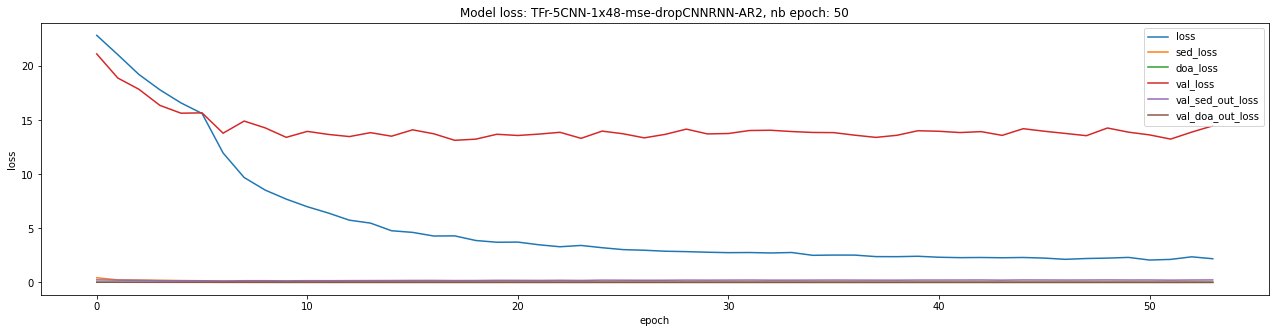

In [17]:
import os
import json
import matplotlib.pyplot as plt
import ast 
#split_folder = os.path.join(output_dir, 'split_{}'.format(split_cnt))
split_folder = os.path.join(output_dir, 'split_{}'.format(0))
datafilepath = split_folder + '/data.json'
history_folder = os.path.join(split_folder, 'history/')

#print(datafilepath)
loss = []
sed_out_loss = []
doa_out_loss = []
val_loss = []
sed_out_val_loss = []
doa_out_val_loss = []

with open(datafilepath) as fp:
  data = json.load(fp)

nb_epoch = data['epoch']
#nb_epoch = 70

#print(data)
for epoch_cnt in range(nb_epoch):
  hist_loss_filename = os.path.join("".join([history_folder, 'pred_%s_%s_hist_loss.json' % (dataset, str(epoch_cnt))]))
  with open(hist_loss_filename) as fp:
    hist_loss = json.load(fp)
    hist_loss = ast.literal_eval(hist_loss) 
    if len(loss) == 0:
      loss = hist_loss['loss']
      sed_out_loss = hist_loss['sed_out_loss']
      doa_out_loss = hist_loss['doa_out_loss']
      val_loss = hist_loss['val_loss']
      sed_out_val_loss = hist_loss['val_sed_out_loss']
      doa_out_val_loss = hist_loss['val_doa_out_loss']
    else:
      loss.append(hist_loss['loss'][0])
      sed_out_loss.append(hist_loss['sed_out_loss'][0])
      doa_out_loss.append(hist_loss['doa_out_loss'][0])
      val_loss.append(hist_loss['val_loss'][0])
      sed_out_val_loss.append(hist_loss['val_sed_out_loss'][0])
      doa_out_val_loss.append(hist_loss['val_doa_out_loss'][0])


plt.figure(figsize=(22, 5))
plt.plot(loss)
plt.plot(sed_out_loss)
plt.plot(doa_out_loss)
plt.plot(val_loss)
plt.plot(sed_out_val_loss)
plt.plot(doa_out_val_loss)
plt.title('Model loss: {}, nb epoch: {}'.format(network, nb_epoch))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'sed_loss', 'doa_loss', 'val_loss', 'val_sed_out_loss', 'val_doa_out_loss'], loc='upper right')
plt.show()